## Análise de Demandas da Fatec de Mauá (2/3) - P2 Machine Learning - Projeção com algoritmo ARIMA

Feito por:

- Adriano das Chagas Barros
- Brendon Gomes da Silva
- Elias Sousa Barbosa
- Rafael Ricardo Gonçalves

Foi feito a análise e interpretação de dados utilizando Regressão Linear e Pearson, com base em um caso de uso real para verificação do estado atual da demanda de inscritos dos cursos da Fatec de Mauá.

### Coleta dos dados

A coleta de dados foi realizada durante todo o período de divulgação da lista de inscritos Fatec de Mauá, desde 2007 a até 2025 (1º Semestre)

Para o processo de coleta de dados, foi uma Automação em C# .NET Framework com Selenium feito para automatizar o download de arquivos da demanda da FATEC de Mauá. Ele realiza o processo de web scrapping e navegação de extração das demandas de forma prática e rápida, exportando em um arquivo CSV.

Fonte dos dados: [Execução da automação - Fatec Demanda Downloader (.NET Framework)](https://github.com/Brendon3578/FatecDemandaDownloaderNetFramework)

## Normalização e Estrutura dos Dados

O processo de normalização padronizou os nomes dos cursos, períodos e colunas, permitindo comparações diretas e análises agregadas. Foram consideradas apenas as modalidades presenciais e noturnas, com os cursos principais: Polímeros, Logística, Informática para Negócios, Fabricação Mecânica e Desenvolvimento de Software Multiplataforma.

- Os nomes dos cursos foram padronizados para evitar duplicidade (ex: "Logística" que inicialmente possuia outro nome, etc.).
- Os períodos foi padronizado para "noite" em vez de noturno, etc.
- Os dados foram analisados tanto por semestre (alguns gráficos que possuem com coluna auxiliar ano_semestre, ex: 2025.0, 2025.5) quanto por ano (soma dos dois semestres).

In [ ]:
import pandas as pd
import re

def carregar_e_normalizar_fatec(path="fatec_demanda_data.csv"):
    # Carregar o arquivo
    df = pd.read_csv(path, sep=",")
    # Normalizar nomes das colunas
    df.columns = df.columns.str.strip().str.lower()
    # Normalizar textos
    df["curso"] = df["curso"].str.strip().str.lower()
    df["periodo"] = df["periodo"].str.strip().str.lower()
    df["fatec"] = df["fatec"].str.strip().str.lower()
    # Corrigir nomes de períodos
    df["periodo"] = df["periodo"].replace({
        "noturno": "noite",
        "matutino": "manhã"
    })
    # Padronizar os cursos conforme as regras
    def normalizar_curso(c):
        if "logística" in c:
            return "logística"
        if re.search(r"polímero|plástic", c):
            return "polímeros"
        if "informática" in c:
            return "informática para negócios"
        return c
    df["curso"] = df["curso"].apply(normalizar_curso)
    # Normalizar tipos numéricos
    for col in ["ano", "semestre", "inscritos", "vagas", "demanda"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

# Exemplo de uso:
df_normalizado = carregar_e_normalizar_fatec()
# Visualize as primeiras linhas para conferir

df_normalizado

,fatec,ano,semestre,curso,periodo,inscritos,vagas,demanda
0,fatec mauá,2007,1,informática para negócios,noite,456,40,11.40
1,fatec mauá,2007,1,informática para negócios,tarde,168,40,4.20
2,fatec mauá,2007,1,polímeros,noite,352,40,8.80
3,fatec mauá,2007,2,informática para negócios,noite,363,40,9.08
4,fatec mauá,2007,2,informática para negócios,tarde,112,40,2.80
...,...,...,...,...,...,...,...,...
243,fatec mauá,2025,1,informática para negócios,manhã,42,24,1.75
244,fatec mauá,2025,1,informática para negócios,noite,105,34,3.09
245,fatec mauá,2025,1,logística,manhã,39,24,1.63
246,fatec mauá,2025,1,logística,noite,120,34,3.53


## Projeções ARIMA - Por 1º Semestre e Período Noturno

### Tendências históricas

- Polímeros: Forte tendência de queda. Em 2007, havia mais de 300 inscritos por semestre; em 2025, menos de 50. O ARIMA projeta estabilização em patamares baixos, refletindo a perda de interesse por áreas industriais tradicionais.
- Informática para Negócios: Após um pico em 2010-2015, a demanda caiu e estabilizou em torno de 100-120 inscritos por semestre. O ARIMA prevê manutenção desse patamar, sem sinais de recuperação relevante.
- Logística: Apresentou alta demanda até meados da década de 2010, mas também entrou em declínio, com previsões de estabilização abaixo de 150 inscritos/semestre.
- Fabricação Mecânica: Segue queda semelhante a Polímeros, com previsão de manutenção em patamares baixos.
- Desenvolvimento de Software Multiplataforma (DSM): Curso recente, mas já com alta demanda (acima de 300 inscritos por semestre). O ARIMA projeta manutenção ou leve crescimento, refletindo a tendência estadual e nacional de alta procura por cursos de tecnologia.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


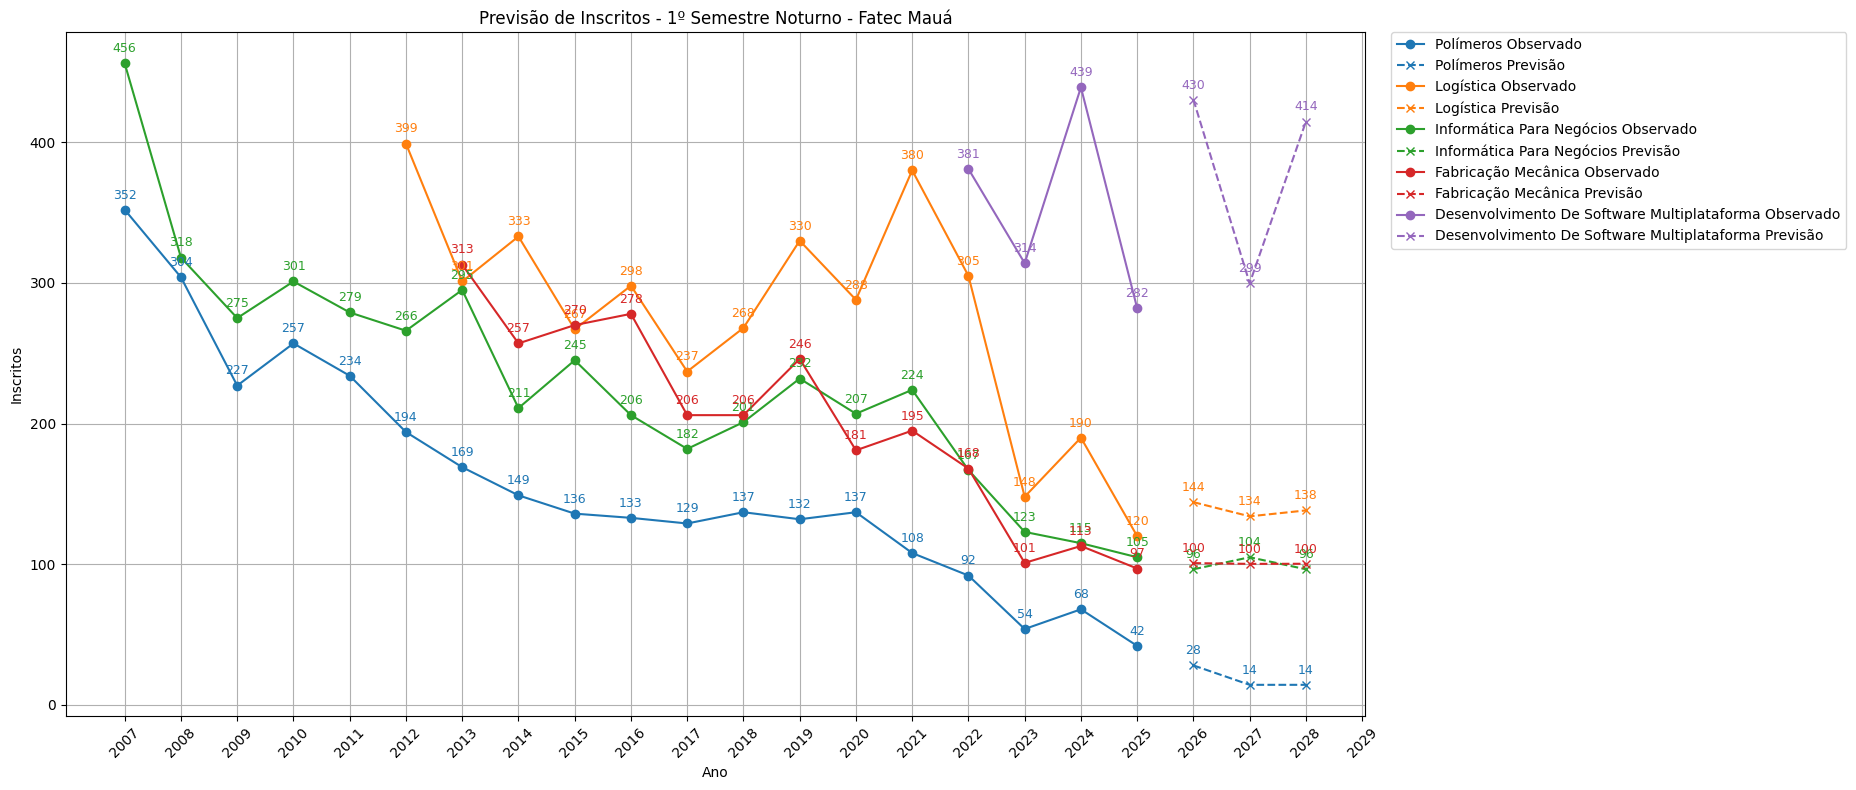

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

# Carregar dados do arquivo CSV e Normalizar colunas
df = carregar_e_normalizar_fatec()

cursos = [
    "polímeros",
    "logística",
    "informática para negócios",
    "fabricação mecânica",
    "desenvolvimento de software multiplataforma"
]

plt.figure(figsize=(14, 8))
cores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i, curso in enumerate(cursos):
    df_curso = df[
        (df["semestre"] == 1) &
        (df["periodo"] == "noite") &
        (df["curso"] == curso)
    ].sort_values("ano")

    if len(df_curso) < 3:
        continue

    anos = df_curso['ano'].values
    serie_inscritos = df_curso['inscritos'].values

    try:
        model = ARIMA(serie_inscritos, order=(1,1,1))
        model_fit = model.fit()
        n_forecast = 3
        forecast = model_fit.forecast(steps=n_forecast)

        # Corrigir valores negativos ou zero: se <= 10, usar o último valor válido anterior
        forecast_corrected = []
        last_valid = serie_inscritos[-1]
        for val in forecast:
            if val <= 10:
                forecast_corrected.append(last_valid)
            else:
                forecast_corrected.append(val)
                last_valid = val
        forecast_corrected = np.array(forecast_corrected)

    except:
        continue

    anos_previstos = np.arange(anos[-1]+1, anos[-1]+1+n_forecast)

    plt.plot(anos, serie_inscritos, marker='o', color=cores[i], label=f'{curso.title()} Observado')
    for x, y in zip(anos, serie_inscritos):
        plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color=cores[i])

    plt.plot(anos_previstos, forecast_corrected, marker='x', linestyle='--', color=cores[i], label=f'{curso.title()} Previsão')
    for x, y in zip(anos_previstos, forecast_corrected):
        plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color=cores[i])

anos_validos = set()
for curso in cursos:
    df_curso = df[
        (df["semestre"] == 1) &
        (df["periodo"] == "noite") &
        (df["curso"] == curso)
    ]
    anos_validos.update(df_curso['ano'].dropna().astype(int).tolist())
    if len(df_curso) >= 3:
        ultimo_ano = int(df_curso['ano'].max())
        anos_validos.update(range(ultimo_ano + 1, ultimo_ano + 5))

anos_xticks = sorted(anos_validos)
plt.xticks(anos_xticks, rotation=45)

plt.xlabel('Ano')
plt.ylabel('Inscritos')
plt.title('Previsão de Inscritos - 1º Semestre Noturno - Fatec Mauá')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.show()


## Projeção e Interpretação Individual

Foi realizado a previsão do número de inscritos para cada curso da Fatec Mauá (1º semestre, período noturno) usando o modelo ARIMA(1,1,1). O procedimento é:

- Divisão treino/teste: 80% dos dados para treino, 20% para teste.
- Ajuste do modelo ARIMA: o modelo é treinado apenas com os dados de treino.
- Previsão e avaliação: o modelo prevê os valores do período de teste.

Cálculo das métricas de acurácia:

- RMSE (Root Mean Squared Error): raiz do erro quadrático médio.
- MAE (Mean Absolute Error): erro absoluto médio.
- MAPE (Mean Absolute Percentage Error): erro percentual absoluto médio.

Visualização: gráfico com histórico (treino), teste (real), previsão ARIMA, com intervalo de confiança e os valores das métricas no título.

## Interpretação das Métricas

- RMSE: Mede o erro médio das previsões, penalizando mais fortemente grandes desvios. Quanto menor, melhor o ajuste. É sensível a outliers.
- MAE: Mede o erro médio absoluto, ou seja, a média das diferenças absolutas entre previsto e real. É menos sensível a outliers que o RMSE.
- MAPE: Mede o erro percentual médio absoluto, permitindo comparar erros entre séries de diferentes escalas. Um MAPE abaixo de 10% é considerado excelente para previsão; até 20% é bom; acima de 30% indica previsões pouco confiáveis

## Análise dos resultados esperados

### a) Cursos com tendência de queda (Polímeros, Fabricação Mecânica)

- Histórico: Queda acentuada nas inscrições ao longo dos anos.
- Previsão ARIMA: O modelo tende a projetar estabilização em patamares baixos, refletindo o padrão histórico.
- Métricas: RMSE e MAE moderados, MAPE pode ser alto em anos recentes devido à baixa base de inscritos (pequenas diferenças geram grandes percentuais).
- Interpretação: O modelo captura bem a tendência de queda, mas a acurácia percentual pode ser prejudicada por valores baixos de inscritos.

### b) Cursos com estabilização ou leve queda (Informática para Negócios, Logística)

- Histórico: Após picos em 2010-2015, as inscrições caíram e estabilizaram.
- Previsão ARIMA: O modelo prevê manutenção dos patamares atuais, sem grandes oscilações.
- Métricas: RMSE e MAE baixos a moderados, MAPE geralmente abaixo de 20%, indicando boa aderência da previsão ao real.
- Interpretação: O ARIMA é adequado para séries estáveis, fornecendo previsões confiáveis e com baixo erro percentual.

### c) Falta de dados: (Desenvolvimento de Software Multiplataforma)

Não foi possível a realização da projeção com teste de acuracidade devido a pouca quantidade

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


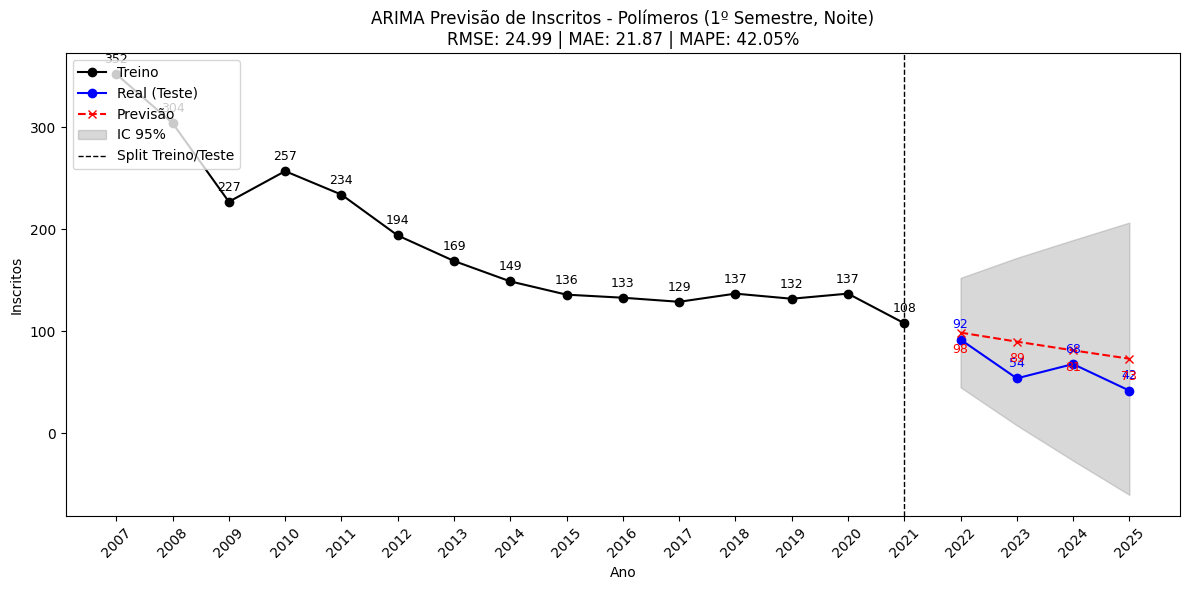

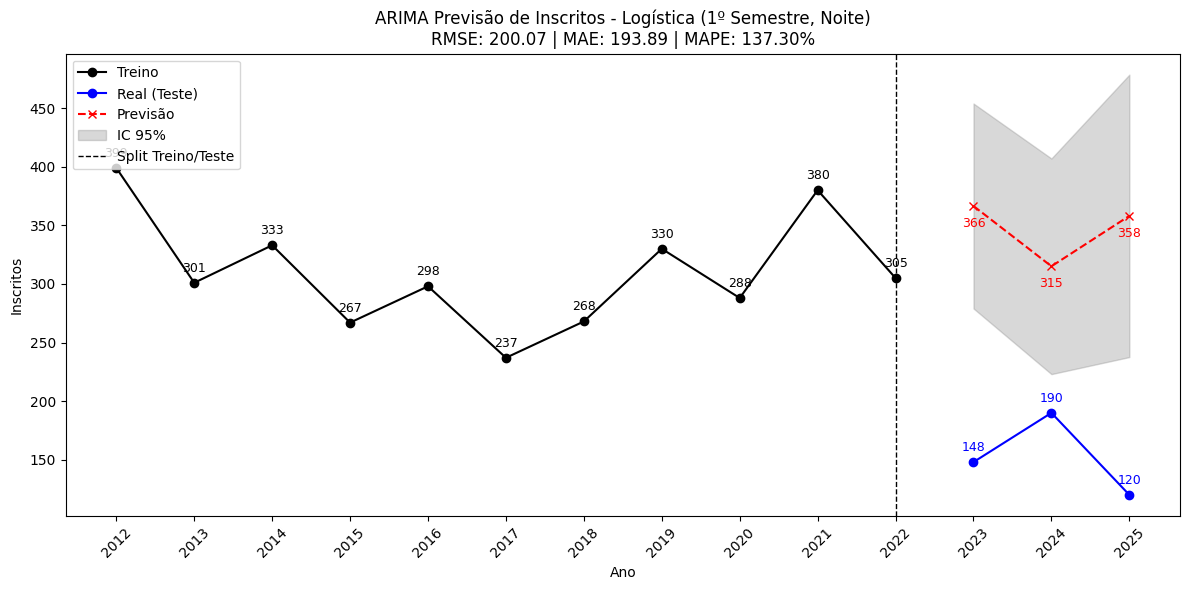

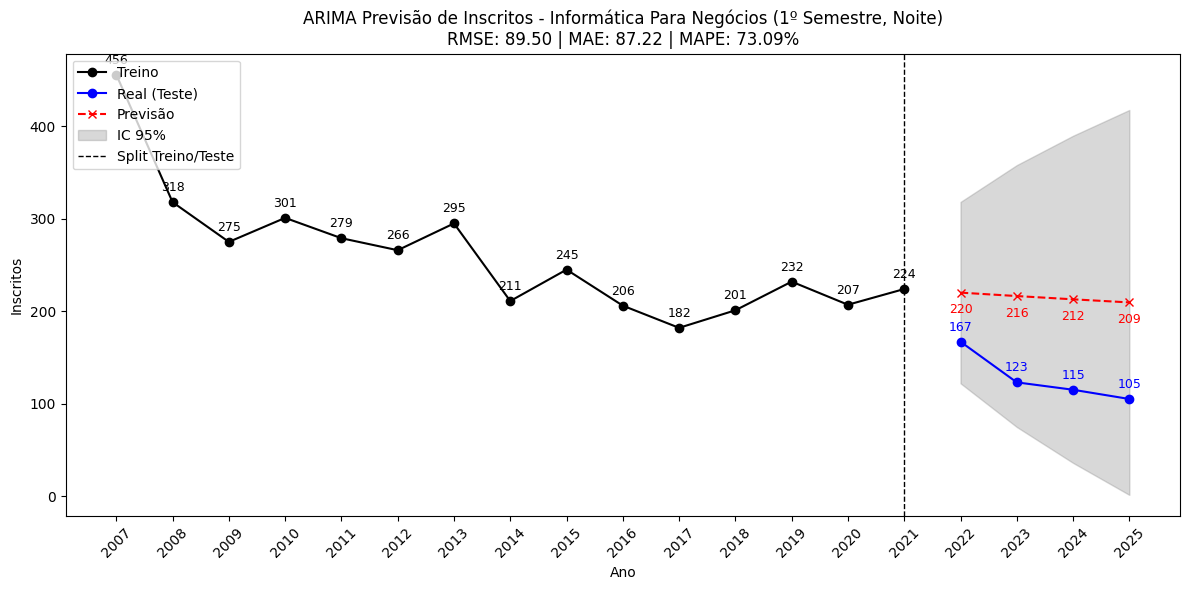

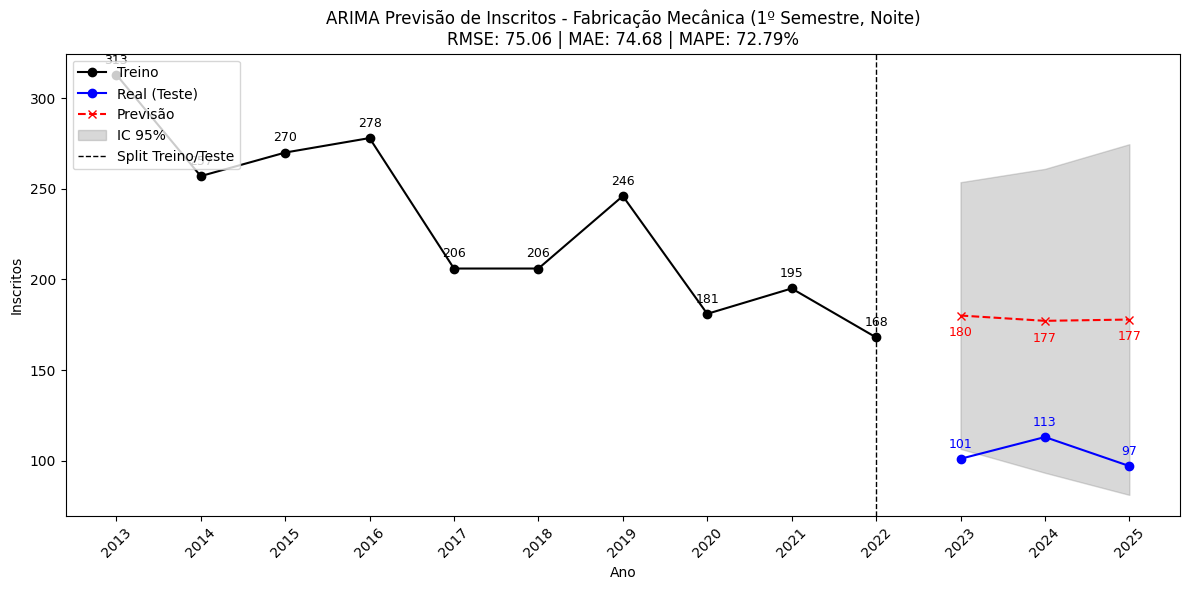

Poucos dados para Desenvolvimento De Software Multiplataforma, pulando...



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Função para calcular o MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Evita divisão por zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan

# Carregar os dados
df = carregar_e_normalizar_fatec()

cursos = [
    "polímeros",
    "logística",
    "informática para negócios",
    "fabricação mecânica",
    "desenvolvimento de software multiplataforma"
]

for curso_escolhido in cursos:
    df_curso = df[
        (df["curso"] == curso_escolhido) &
        (df["semestre"] == 1) &
        (df["periodo"] == "noite")
    ].sort_values("ano")

    anos = df_curso["ano"].values
    inscritos = df_curso["inscritos"].values

    # Só faz a previsão se há dados suficientes
    if len(inscritos) < 6:
        print(f"Poucos dados para {curso_escolhido.title()}, pulando...\n")
        continue

    # Divisão treino/teste (80% treino, 20% teste)
    train_size = int(len(inscritos) * 0.80)
    train, test = inscritos[:train_size], inscritos[train_size:]
    anos_train, anos_test = anos[:train_size], anos[train_size:]

    # Ajustar ARIMA apenas no treino
    try:
        model = ARIMA(train, order=(1,1,1))
        model_fit = model.fit()
    except:
        print(f"Erro ao ajustar ARIMA para {curso_escolhido.title()}, pulando...\n")
        continue

    # Prever sobre o período de teste
    forecast_result = model_fit.get_forecast(steps=len(test))
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)
    conf_int = np.asarray(conf_int)

    # Calcular métricas de acurácia
    if len(test) > 0:
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        mape = mean_absolute_percentage_error(test, forecast)
    else:
        rmse = mae = mape = np.nan

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(anos_train, train, color='black', marker='o', label="Treino")
    if len(test) > 0:
        plt.plot(anos_test, test, color='blue', marker='o', label="Real (Teste)")
        plt.plot(anos_test, forecast, color='red', marker='x', linestyle='--', label="Previsão")
        plt.fill_between(anos_test, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3, label="IC 95%")
        plt.axvline(x=anos_train[-1], color='k', linestyle='--', lw=1, label="Split Treino/Teste")
    else:
        plt.axvline(x=anos_train[-1], color='k', linestyle='--', lw=1, label="Fim do Treino")

    # Mostra todos os anos no eixo x
    anos_todos = np.unique(np.concatenate([anos_train, anos_test]))
    plt.xticks(anos_todos, rotation=45)

    # Adiciona os valores nos pontos do gráfico
    for x, y in zip(anos_train, train):
        plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9)
    for x, y in zip(anos_test, test):
        plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color='blue')
    for x, y in zip(anos_test, forecast):
        plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color='red')

    plt.xlabel("Ano")
    plt.ylabel("Inscritos")
    plt.title(
        f"ARIMA Previsão de Inscritos - {curso_escolhido.title()} (1º Semestre, Noite)\n"
        f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%"
    )
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


## Projeção por ano (soma dos semestres)

- O agrupamento anual reforça as tendências já vistas nos dados semestrais, mas suaviza eventuais oscilações de um semestre para outro.
- A queda em Polímeros e Fabricação Mecânica fica ainda mais clara, assim como a estagnação em Informática para Negócios e Logística.
- O crescimento de DSM é ainda mais evidente quando se observa o total anual de inscritos.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


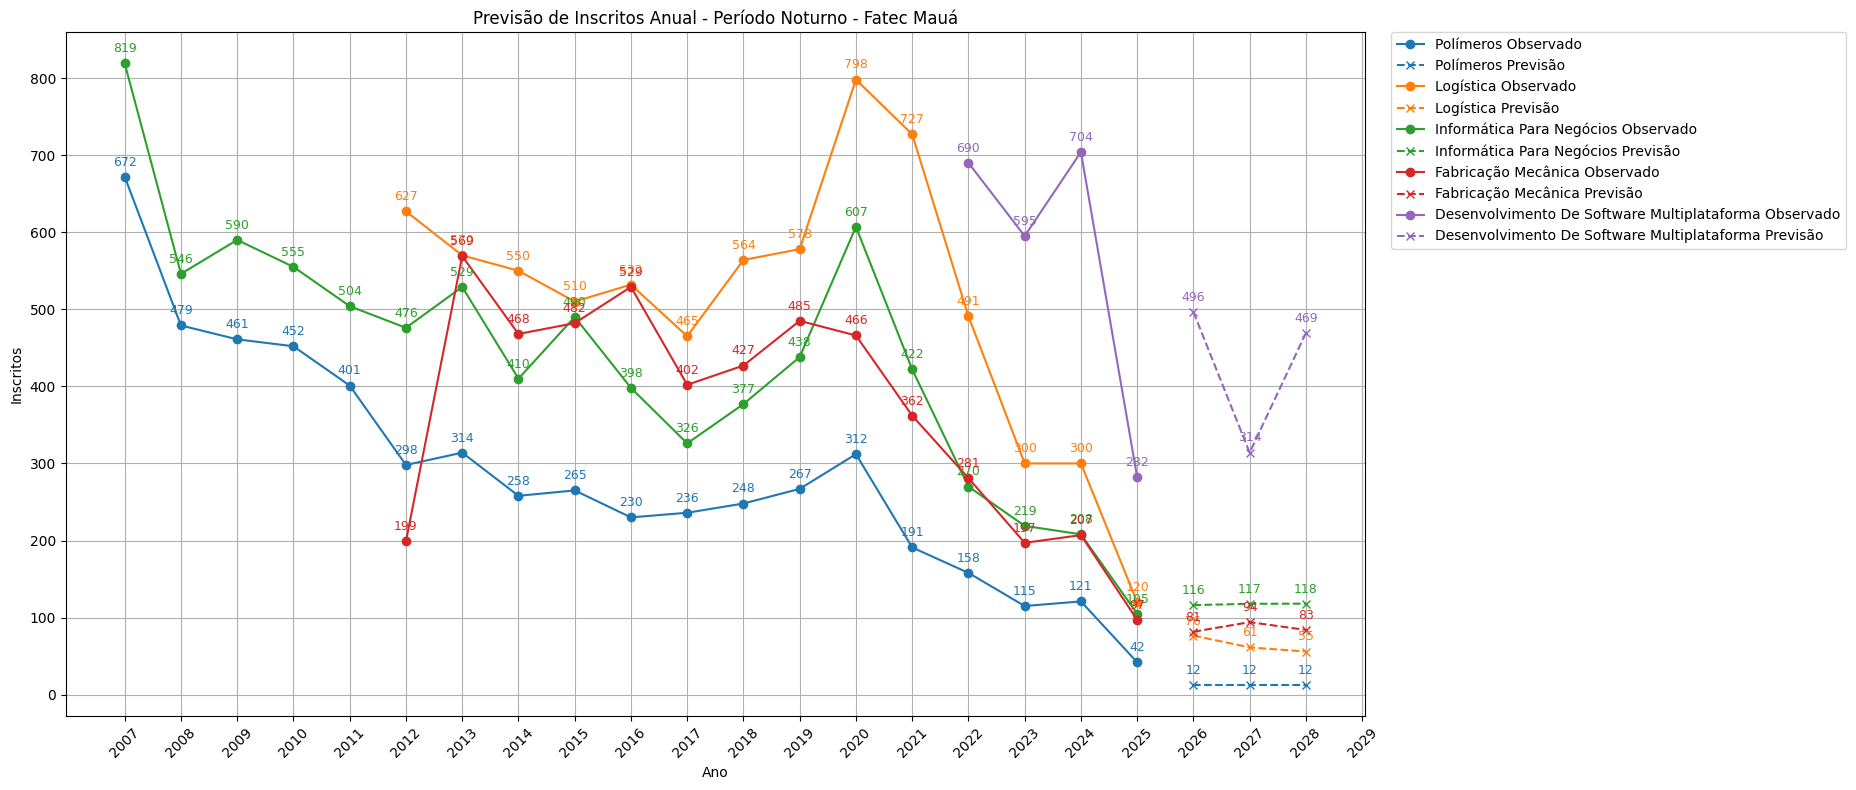

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import re

# Carregar e normalizar os dados
df = pd.read_csv("fatec_demanda_data.csv", sep=",")
df.columns = df.columns.str.strip().str.lower()

def normalizar_curso(c):
    c = c.lower().strip()
    if "logística" in c:
        return "logística"
    if re.search(r"polímero|plástic", c):
        return "polímeros"
    if "informática" in c:
        return "informática para negócios"
    return c

df["curso"] = df["curso"].apply(normalizar_curso)
df["periodo"] = df["periodo"].str.strip().str.lower().replace({"noturno": "noite", "matutino": "manhã"})

for col in ["ano", "semestre", "inscritos", "vagas", "demanda"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filtrar apenas período noturno
df_noite = df[df["periodo"] == "noite"]

# Agrupar por ano e curso somando os inscritos dos dois semestres
df_agrupado = df_noite.groupby(["ano", "curso"])['inscritos'].sum().reset_index()

cursos = [
    "polímeros",
    "logística",
    "informática para negócios",
    "fabricação mecânica",
    "desenvolvimento de software multiplataforma"
]

plt.figure(figsize=(14, 8))
cores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i, curso in enumerate(cursos):
    df_curso = df_agrupado[df_agrupado["curso"] == curso].sort_values("ano")
    anos = df_curso['ano'].values
    inscritos = df_curso['inscritos'].values

    if len(inscritos) < 3:
        continue

    try:
        model = ARIMA(inscritos, order=(1,1,1))
        model_fit = model.fit()
        n_forecast = 3
        forecast = model_fit.forecast(steps=n_forecast)

        # Corrigir valores negativos ou zero: se <= 10, usar o último valor válido anterior
        forecast_corrected = []
        last_valid = inscritos[-1]
        for val in forecast:
            if val <= 10:
                forecast_corrected.append(last_valid)
            else:
                forecast_corrected.append(val)
                last_valid = val
        forecast_corrected = np.array(forecast_corrected)

    except:
        continue

    anos_previstos = np.arange(anos[-1]+1, anos[-1]+1+n_forecast)

    plt.plot(anos, inscritos, marker='o', color=cores[i], label=f'{curso.title()} Observado')
    for x, y in zip(anos, inscritos):
        plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color=cores[i])

    plt.plot(anos_previstos, forecast_corrected, marker='x', linestyle='--', color=cores[i], label=f'{curso.title()} Previsão')
    for x, y in zip(anos_previstos, forecast_corrected):
        plt.annotate(f"{int(y)}", (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color=cores[i])

anos_validos = set()
for curso in cursos:
    df_curso = df_agrupado[df_agrupado["curso"] == curso]
    anos_validos.update(df_curso['ano'].dropna().astype(int).tolist())
    if len(df_curso) >= 3:
        ultimo_ano = int(df_curso['ano'].max())
        anos_validos.update(range(ultimo_ano + 1, ultimo_ano + 5))

anos_xticks = sorted(anos_validos)
plt.xticks(anos_xticks, rotation=45)

plt.xlabel('Ano')
plt.ylabel('Inscritos')
plt.title('Previsão de Inscritos Anual - Período Noturno - Fatec Mauá')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.show()


## Análise da projeção por ano e Semestre juntos

- Cursos industriais tradicionais (Polímeros, Fabricação Mecânica) estão em trajetória de queda e estabilização baixa, sugerindo necessidade de revisão curricular ou estratégias de captação.
- Cursos de gestão/negócios (Informática para Negócios, Logística) estabilizaram em patamar intermediário, ainda relevantes, mas sem crescimento.
- Cursos de tecnologia (DSM) são os únicos com alta demanda e perspectiva positiva, alinhados ao cenário estadual e nacional.

## Interpretação geral

- Polímeros: Queda estrutural, estabilização em 40-42 inscritos/semestre.
- Logística: Após pico, estabilização em 110-124 inscritos/semestre.
- Informática para Negócios: Estável em 100-124 inscritos/semestre.
- Fabricação Mecânica: Estabilização em torno de 94-124 inscritos/semestre.
- DSM: Manutenção de alta demanda (282-325), consolidando-se como principal curso em interesse.



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


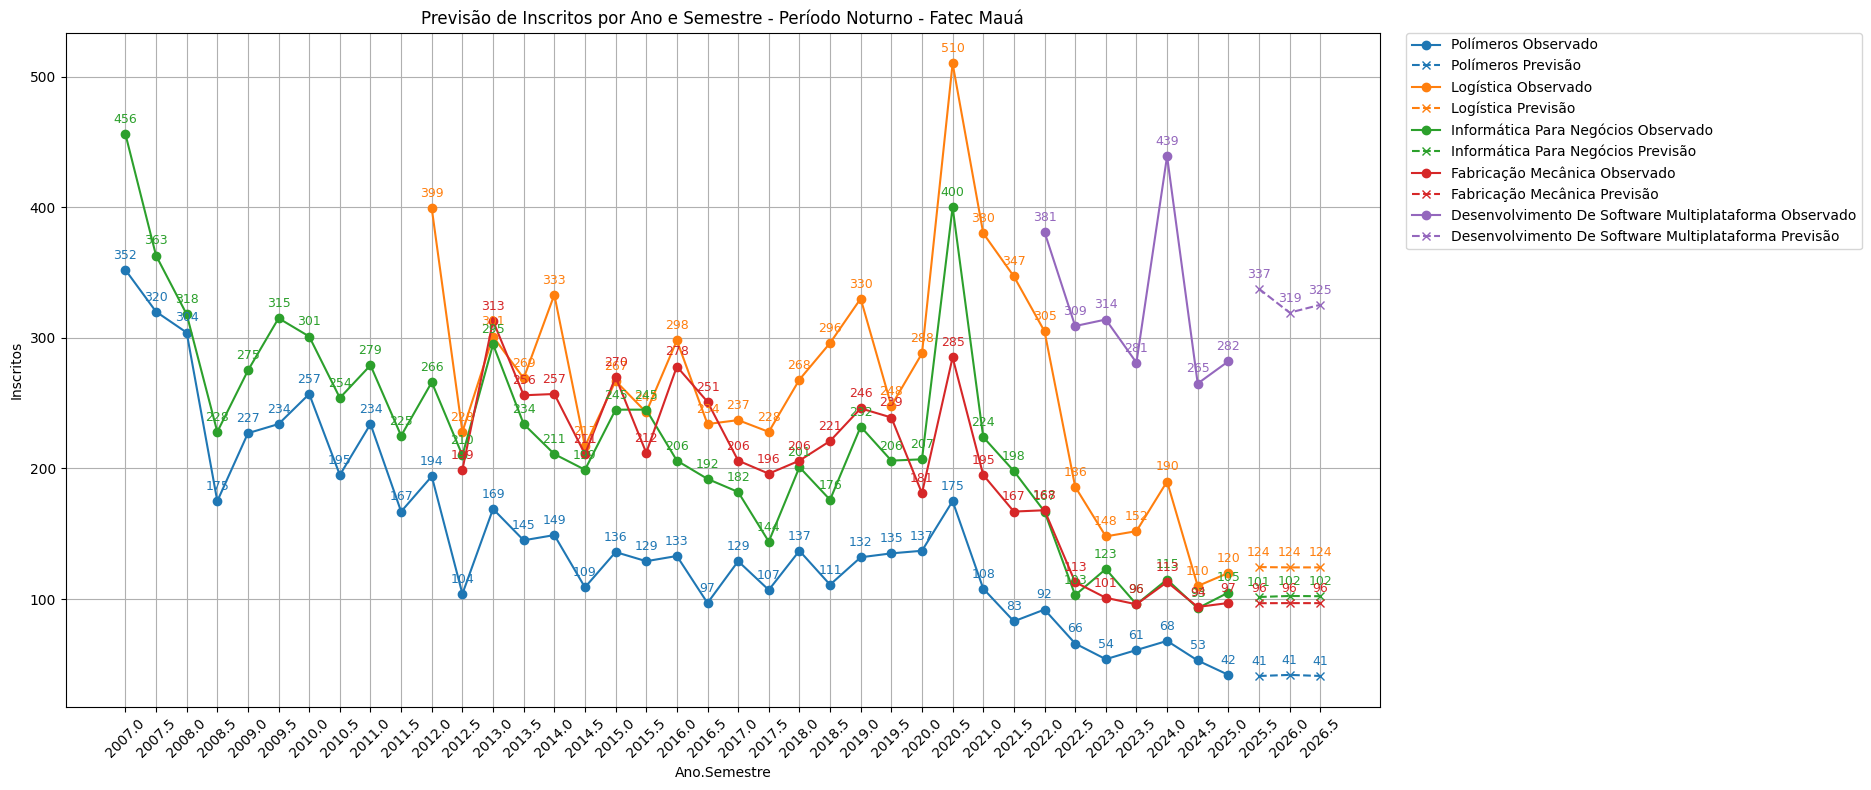

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import re

# Carregar e normalizar os dados
df = pd.read_csv("fatec_demanda_data.csv", sep=",")
df.columns = df.columns.str.strip().str.lower()

def normalizar_curso(c):
    c = c.lower().strip()
    if "logística" in c:
        return "logística"
    if re.search(r"polímero|plástic", c):
        return "polímeros"
    if "informática" in c:
        return "informática para negócios"
    return c

df["curso"] = df["curso"].apply(normalizar_curso)
df["periodo"] = df["periodo"].str.strip().str.lower().replace({"noturno": "noite", "matutino": "manhã"})
for col in ["ano", "semestre", "inscritos", "vagas", "demanda"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Apenas período noturno
df_noite = df[df["periodo"] == "noite"].copy()

# Criar coluna ano_semestre: 2025.0 para 1º semestre, 2025.5 para 2º semestre
df_noite["ano_semestre"] = df_noite["ano"] + (df_noite["semestre"] - 1) * 0.5

cursos = [
    "polímeros",
    "logística",
    "informática para negócios",
    "fabricação mecânica",
    "desenvolvimento de software multiplataforma"
]

plt.figure(figsize=(14, 8))
cores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i, curso in enumerate(cursos):
    df_curso = df_noite[df_noite["curso"] == curso].sort_values("ano_semestre")
    x = df_curso["ano_semestre"].values
    y = df_curso["inscritos"].values

    if len(y) < 3:
        continue

    try:
        model = ARIMA(y, order=(1,1,1))
        model_fit = model.fit()
        n_forecast = 3
        # Previsão para os próximos 3 semestres (1,5 anos)
        forecast = model_fit.forecast(steps=n_forecast)
        # Corrigir valores negativos ou zero
        forecast_corrected = []
        last_valid = y[-1]
        for val in forecast:
            if val <= 10:
                forecast_corrected.append(last_valid)
            else:
                forecast_corrected.append(val)
                last_valid = val
        forecast_corrected = np.array(forecast_corrected)
    except:
        continue

    # Índices para os próximos semestres
    last_ano = df_curso["ano"].iloc[-1]
    last_sem = df_curso["semestre"].iloc[-1]
    next_ano_sem = []
    ano = last_ano
    sem = last_sem
    for _ in range(n_forecast):
        if sem == 1:
            sem = 2
            ano_sem = ano + 0.5
        else:
            sem = 1
            ano += 1
            ano_sem = ano
        next_ano_sem.append(ano_sem)
    next_ano_sem = np.array(next_ano_sem)

    # Plot histórico
    plt.plot(x, y, marker='o', color=cores[i], label=f'{curso.title()} Observado')
    for xi, yi in zip(x, y):
        plt.annotate(f"{int(yi)}", (xi, yi), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color=cores[i])

    # Plot previsão
    plt.plot(next_ano_sem, forecast_corrected, marker='x', linestyle='--', color=cores[i], label=f'{curso.title()} Previsão')
    for xi, yi in zip(next_ano_sem, forecast_corrected):
        plt.annotate(f"{int(yi)}", (xi, yi), textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color=cores[i])

anos_semestres_validos = set(df_noite["ano_semestre"].dropna().tolist())
for curso in cursos:
    df_curso = df_noite[df_noite["curso"] == curso]
    if len(df_curso) >= 3:
        last_ano = df_curso["ano"].iloc[-1]
        last_sem = df_curso["semestre"].iloc[-1]
        ano = last_ano
        sem = last_sem
        for _ in range(3):
            if sem == 1:
                sem = 2
                ano_sem = ano + 0.5
            else:
                sem = 1
                ano += 1
                ano_sem = ano
            anos_semestres_validos.add(ano_sem)

plt.xticks(sorted(anos_semestres_validos), rotation=45)
plt.xlabel('Ano.Semestre')
plt.ylabel('Inscritos')
plt.title('Previsão de Inscritos por Ano e Semestre - Período Noturno - Fatec Mauá')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.show()
